In [1]:
# !pip install pandas-datareader

In [1]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from math import log
from datetime import datetime
from datetime import datetime, date, time, timezone
from datetime_truncate import truncate

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
from scipy import stats

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

### Data preparation. Part 1

In [2]:
######## download data #########

df = pd.read_csv('/Users/k.dortsev/Desktop/btcusdt_5m.csv')
df['open_time'] = pd.to_datetime(df['open_time'], unit = 'ms')
df.rename(columns = {"open_time":"Date"}, inplace = True)
df = df.set_index('Date')
df

,open,high,low,close,volume,close_time,quote_vol,trades,buy_vol,buy_q_vol,ignore
Date,,,,,,,,,,,
2018-11-06 04:30:00,6456.43,6463.71,6456.11,6456.33,23.008103,1541478899999,1.486066e+05,427,9.339141,6.032264e+04,0
2018-11-06 04:35:00,6461.42,6462.66,6456.46,6460.46,11.834372,1541479199999,7.644766e+04,271,4.843510,3.129478e+04,0
2018-11-06 04:40:00,6460.46,6463.04,6456.21,6456.21,18.530013,1541479499999,1.196980e+05,370,7.267866,4.694694e+04,0
2018-11-06 04:45:00,6457.51,6457.64,6451.12,6455.19,23.404549,1541479799999,1.510820e+05,351,11.081347,7.153750e+04,0
2018-11-06 04:50:00,6451.13,6455.18,6451.13,6452.34,11.211013,1541480099999,7.234625e+04,264,4.181247,2.698751e+04,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-03 12:05:00,20152.16,20178.95,20135.64,20164.10,1935.068400,1667477399999,3.901515e+07,41686,1033.620520,2.084035e+07,0
2022-11-03 12:10:00,20163.65,20165.30,20117.64,20141.13,1342.865580,1667477699999,2.703642e+07,29318,657.534660,1.323853e+07,0
2022-11-03 12:15:00,20140.32,20147.56,20114.61,20121.36,1282.877480,1667477999999,2.582250e+07,28308,605.825600,1.219466e+07,0


In [3]:
######## some unnecessary columns ###########

columns_to_drop = ['open', 'high', 'low', 'volume', 'close_time', 'quote_vol',
       'trades', 'buy_vol', 'buy_q_vol', 'ignore']

df = df.drop(columns_to_drop, axis = 1)
df = df.dropna()
df.head(1000)

,close
Date,
2018-11-06 04:30:00,6456.33
2018-11-06 04:35:00,6460.46
2018-11-06 04:40:00,6456.21
2018-11-06 04:45:00,6455.19
2018-11-06 04:50:00,6452.34
...,...
2018-11-09 15:25:00,6423.00
2018-11-09 15:30:00,6427.96
2018-11-09 15:35:00,6432.06


In [4]:
df.to_csv('df.csv', header=True, sep=',')
# df

### Data preparation. Part 2

In [5]:
############ Compute number of periods/day ##################
df["D"] = df.index.date
n_periods = df.pivot_table(index = ["D"], aggfunc = 'size').values

stats.describe(n_periods)

DescribeResult(nobs=1459, minmax=(150, 408), mean=287.8684030157642, variance=86.5917238539278, skewness=-2.893216864351894, kurtosis=101.53662667441972)

In [6]:
df.fillna(method = 'ffill', inplace = True)

df["Ret_sqr"] =  (np.log(df.close) - np.log(df.close).shift(1))**2
df.dropna()

,close,D,Ret_sqr
Date,,,
2018-11-06 04:35:00,6460.46,2018-11-06,4.089318e-07
2018-11-06 04:40:00,6456.21,2018-11-06,4.330487e-07
2018-11-06 04:45:00,6455.19,2018-11-06,2.496397e-08
2018-11-06 04:50:00,6452.34,2018-11-06,1.950129e-07
2018-11-06 04:55:00,6458.20,2018-11-06,8.240745e-07
...,...,...,...
2022-11-03 12:05:00,20164.10,2022-11-03,3.913309e-07
2022-11-03 12:10:00,20141.13,2022-11-03,1.299150e-06
2022-11-03 12:15:00,20121.36,2022-11-03,9.644332e-07


In [7]:
# Perform the sum grouped by days.
rv = df.groupby("D")["Ret_sqr"].agg(np.sum).to_frame()
rv.rename(columns = {"Ret_sqr": "RV_daily"}, inplace = True)
rv

,RV_daily
D,
2018-11-06,0.000097
2018-11-07,0.000168
2018-11-08,0.000151
2018-11-09,0.000129
2018-11-10,0.000052
...,...
2022-10-30,0.000222
2022-10-31,0.000520
2022-11-01,0.000181


In [8]:
######## Compute weekly and monthly RV ############# 
# rv["2_days"] = rv["RV_daily"].rolling(2).mean() # for 2 days
# rv["3_days"] = rv["RV_daily"].rolling(3).mean() # for 2 days
# rv["4_days"] = rv["RV_daily"].rolling(4).mean() # for 3 days
rv["RV_weekly"] = rv["RV_daily"].rolling(5).mean()
# rv["6_days"] = rv["RV_daily"].rolling(6).mean() # for 6 days
rv["RV_monthly"] = rv["RV_daily"].rolling(21).mean()
rv.dropna(inplace = True)
rv

,RV_daily,RV_weekly,RV_monthly
D,,,
2018-11-26,0.007050,0.005181,0.002764
2018-11-27,0.003332,0.005464,0.002918
2018-11-28,0.003982,0.005690,0.003100
2018-11-29,0.003107,0.005339,0.003241
2018-11-30,0.002984,0.004091,0.003377
...,...,...,...
2022-10-30,0.000222,0.000523,0.000423
2022-10-31,0.000520,0.000410,0.000431
2022-11-01,0.000181,0.000340,0.000423


In [9]:
####### Getting log RV ##########
# rv['Log_2_days'] = np.log(rv['2_days'])
# rv['Log_3_days'] = np.log(rv['3_days'])
# rv['Log_4_days'] = np.log(rv['4_days'])
# rv['Log_6_days'] = np.log(rv['6_days'])
rv['Log_RV_daily'] = np.log(rv['RV_daily'])
rv['Log_RV_weekly'] = np.log(rv['RV_weekly'])
rv['Log_RV_monthly'] = np.log(rv['RV_monthly'])
rv #check

,RV_daily,RV_weekly,RV_monthly,Log_RV_daily,Log_RV_weekly,Log_RV_monthly
D,,,,,,
2018-11-26,0.007050,0.005181,0.002764,-4.954700,-5.262823,-5.890955
2018-11-27,0.003332,0.005464,0.002918,-5.704293,-5.209638,-5.836726
2018-11-28,0.003982,0.005690,0.003100,-5.525959,-5.169000,-5.776359
2018-11-29,0.003107,0.005339,0.003241,-5.774178,-5.232732,-5.731954
2018-11-30,0.002984,0.004091,0.003377,-5.814457,-5.498979,-5.690855
...,...,...,...,...,...,...
2022-10-30,0.000222,0.000523,0.000423,-8.414798,-7.555978,-7.767459
2022-10-31,0.000520,0.000410,0.000431,-7.561256,-7.799218,-7.750058
2022-11-01,0.000181,0.000340,0.000423,-8.614542,-7.985545,-7.769058


### ADF-test for stationarity checking

In [10]:
######## Check for stationarity with adf test ########
# print("p-value for log 2 days RV", adf(rv["Log_2_days"])[1])
# print("p-value for log 3 days RV", adf(rv["Log_3_days"])[1])
# print("p-value for log 4 days RV", adf(rv["Log_4_days"])[1])
# print("p-value for log 6 days RV", adf(rv["Log_6_days"])[1])
print("p-value for daily RV:", adf(rv["Log_RV_daily"].values)[1])
print("p-value for weekly RV:",adf(rv["Log_RV_weekly"].values)[1])
print("p-value for monthly RV:",adf(rv["Log_RV_monthly"].values)[1])

p-value for daily RV: 0.0005396890617099123
p-value for weekly RV: 1.5030423285795109e-05
p-value for monthly RV: 0.012971655340449384


ADF-test shows us that $p-values$ in all cases, excluding monthly logarithmic RV, are smaller than 0.01, so there is stationarity in daily and weekly series

In [11]:
####### First diff #########

rv["Log_RV_monthly_1_diff"] = rv["Log_RV_monthly"].diff(periods=1).dropna()
rv.dropna(inplace = True)
rv

,RV_daily,RV_weekly,RV_monthly,Log_RV_daily,Log_RV_weekly,Log_RV_monthly,Log_RV_monthly_1_diff
D,,,,,,,
2018-11-27,0.003332,0.005464,0.002918,-5.704293,-5.209638,-5.836726,0.054230
2018-11-28,0.003982,0.005690,0.003100,-5.525959,-5.169000,-5.776359,0.060367
2018-11-29,0.003107,0.005339,0.003241,-5.774178,-5.232732,-5.731954,0.044405
2018-11-30,0.002984,0.004091,0.003377,-5.814457,-5.498979,-5.690855,0.041099
2018-12-01,0.001618,0.003005,0.003451,-6.426298,-5.807613,-5.668999,0.021856
...,...,...,...,...,...,...,...
2022-10-30,0.000222,0.000523,0.000423,-8.414798,-7.555978,-7.767459,0.004723
2022-10-31,0.000520,0.000410,0.000431,-7.561256,-7.799218,-7.750058,0.017401
2022-11-01,0.000181,0.000340,0.000423,-8.614542,-7.985545,-7.769058,-0.019000


In [12]:
print("p-value for the first diff for log monthly RV:",adf(rv["Log_RV_monthly_1_diff"].values)[1])

p-value for the first diff for log monthly RV: 5.449560294892324e-19


ADF-test shows that right now the time series are stationary

In [13]:
rv.to_csv('rv.csv', header=True, sep=',')

### Charts

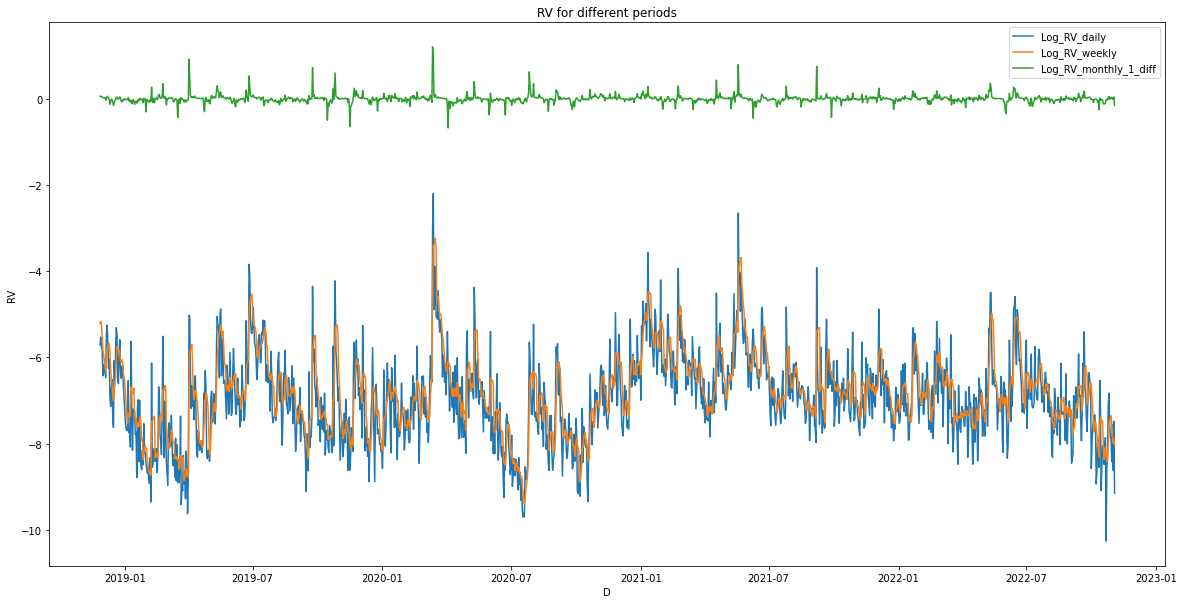

In [14]:
######### Plot the RV variables #############  
rv[["Log_RV_daily","Log_RV_weekly","Log_RV_monthly_1_diff"]].plot(title = "RV for different periods", figsize = (20, 10))
plt.ylabel("RV")
plt.show()

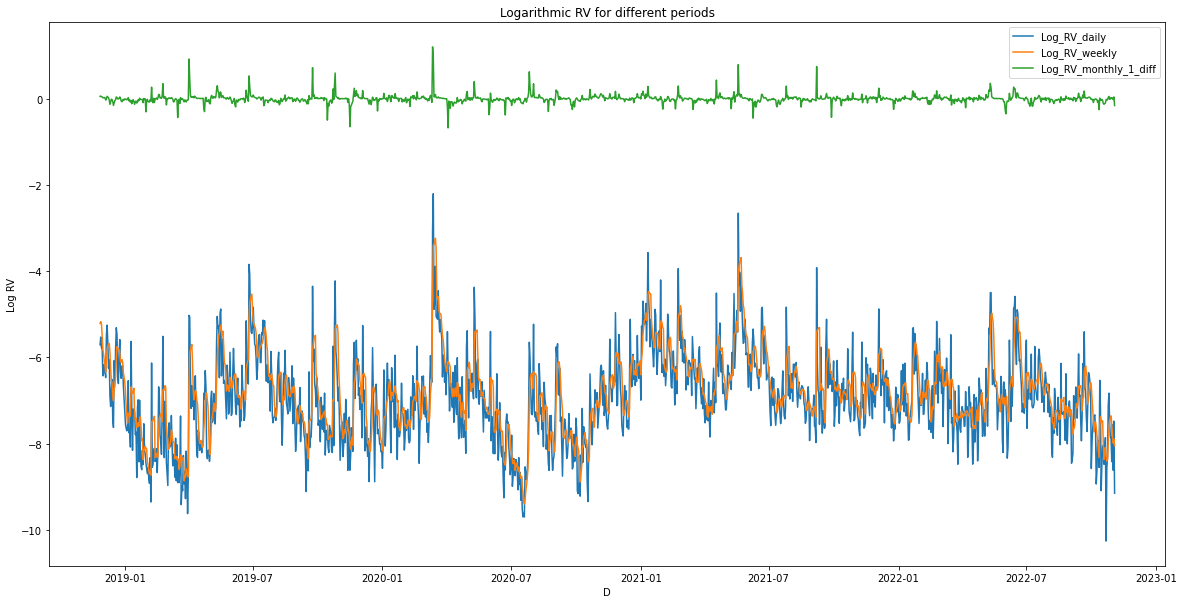

In [15]:
######### Plot the Log RV variables #############

rv[["Log_RV_daily","Log_RV_weekly","Log_RV_monthly_1_diff"]].plot(title = "Logarithmic RV for different periods", figsize = (20, 10))
plt.ylabel("Log RV")
plt.show()

### Test and Train

In [16]:
####### Prepare data #########
rv.drop(["RV_daily", "RV_weekly", "RV_monthly", "Log_RV_monthly"], axis = 1, inplace = True)
rv["Target"] = rv["Log_RV_daily"].shift(-1) # I want to predict the RV of the next day.  
rv.dropna(inplace = True)

######### Scale the data #############
rv_scaled = (rv-rv.min())/(rv.max()-rv.min())

########### Add constant c #############
rv_scaled = sm.add_constant(rv_scaled)

######## #Split train and test sets ##########
split = int(0.60 * rv.shape[0])
X = rv_scaled.drop("Target", axis = 1)
y = rv_scaled[["Target"]]
X_train, X_test = X[:split], X[split:] #I have checked accuracy for train and test samples
y_train, y_test = y[:split], y[split:]

### OLS regression

In [17]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     405.7
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          5.29e-164
Time:                        18:59:19   Log-Likelihood:                 886.49
No. Observations:                 862   AIC:                            -1765.
Df Residuals:                     858   BIC:                            -1746.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.1103      0.018      6.030      0.000       0.074       0.146
Log_RV_daily              0.4843      0.046     10.458      0.000       0.393       0.575
Log_RV_weekly             0.2705      0.036      7.443      0.000       0.199       0.342
Log_RV_monthly_1_diff    -0.0423      0.057     -0.738      0.461      -0.155       0.070
==============================================================================
Omnibus:                      171.126   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              406.767
Skew:                           1.058   Prob(JB):                     4.70e-89
Kurtosis:                       5.617   Cond. No.                         27.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see, $p-value$ for monthly logarithmic RV is very large, so there is no significance for this coefficient 

### Metrics and predictions

In [18]:
########### Perform out of sample prediction ############
y_hat = results.predict(X_test)

In [19]:
############# Metrics ###############
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [20]:
######### In-sample scores ###########
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
############## Out-of-sample scores #############
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.007486129710142758, R^2:0.5864965842702793, MAE:0.06444210622149478
----------------
Out-of-sample scores
MSE:0.00647830902250757, R^2:0.4123074801805129, MAE:0.058575213455657124


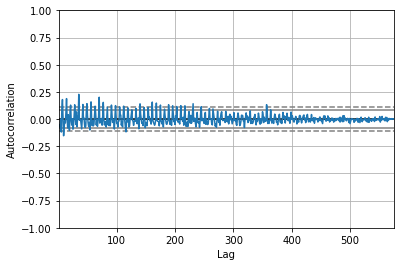

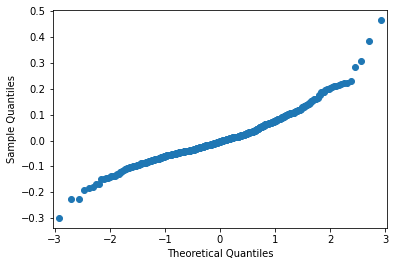

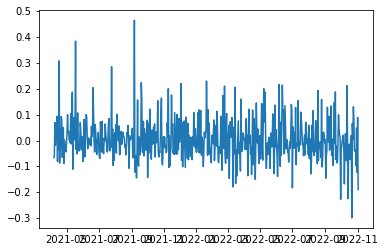

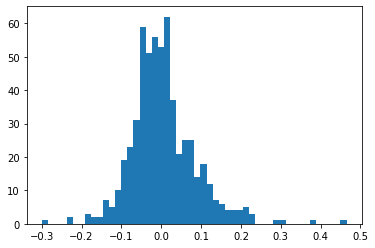

In [21]:
####### Residuals ############
residuals = y_test.values.ravel() - y_hat

autocorrelation_plot(residuals);plt.show()
qqplot(residuals);plt.show()
plt.plot(residuals);plt.show()
plt.hist(residuals, bins = 50); plt.show()

### HAR-free model

In [22]:
data = pd.read_csv('df.csv')
data = data.set_index('Date')
data

,close
Date,
2018-11-06 04:30:00,6456.33
2018-11-06 04:35:00,6460.46
2018-11-06 04:40:00,6456.21
2018-11-06 04:45:00,6455.19
2018-11-06 04:50:00,6452.34
...,...
2022-11-03 12:05:00,20164.10
2022-11-03 12:10:00,20141.13
2022-11-03 12:15:00,20121.36


In [24]:
############ Compute number of periods/day ##################
data["D"] = data.index.date
n_periods = data.pivot_table(index = ["D"], aggfunc = 'size').values

stats.describe(n_periods)

AttributeError: 'Index' object has no attribute 'date'

In [23]:
######## Computing lagged RV ########

data["Ret_1_day_lag"] =  np.log(data.close) - np.log(data.close).shift(1)
# df["Ret_sqr_2_day_lag"] =  (np.log(df.close) - np.log(df.close).shift(2))**2
# df["Ret_sqr_3_day_lag"] =  (np.log(df.close) - np.log(df.close).shift(3))**2
# df["Ret_sqr_4_day_lag"] =  (np.log(df.close) - np.log(df.close).shift(4))**2
# df["Ret_sqr_5_day_lag"] =  (np.log(df.close) - np.log(df.close).shift(5))**2
# df["Ret_sqr_6_day_lag"] =  (np.log(df.close) - np.log(df.close).shift(6))**2
data.drop("close", axis = 1, inplace = True)
data.dropna(inplace = True)
data

,Ret_1_day_lag
Date,
2018-11-06 04:35:00,0.000639
2018-11-06 04:40:00,-0.000658
2018-11-06 04:45:00,-0.000158
2018-11-06 04:50:00,-0.000442
2018-11-06 04:55:00,0.000908
...,...
2022-11-03 12:05:00,0.000626
2022-11-03 12:10:00,-0.001140
2022-11-03 12:15:00,-0.000982


In [27]:
# Perform the sum grouped by days.
rv_1 = data.groupby("Date")["Ret_1_day_lag"].agg(np.sum).to_frame()
# rv_1.rename(columns = {"Ret_sqr": "RV_daily"}, inplace = True)
rv_1

,Ret_1_day_lag
Date,
2018-11-06 04:35:00,0.000639
2018-11-06 04:40:00,-0.000658
2018-11-06 04:45:00,-0.000158
2018-11-06 04:50:00,-0.000442
2018-11-06 04:55:00,0.000908
...,...
2022-11-03 12:05:00,0.000626
2022-11-03 12:10:00,-0.001140
2022-11-03 12:15:00,-0.000982


### LASSO approach

In [28]:
###### Create an instance of Lasso Regression implementation #######

# lasso = Lasso(alpha=1.0)

###### Fit the Lasso model ########

lasso_model = Lasso().fit(X_train, y_train)
lasso_model.coef_


, "Ret_sqr_2_day_lag", "Ret_sqr_3_day_lag", "Ret_sqr_4_day_lag", "Ret_sqr_5_day_lag", "Ret_sqr_6_day_lag"]

array([0., 0., 0.])

In [27]:
X_train = X_train.drop('const', axis = 1)
X_test = X_test.drop('const', axis = 1)

In [29]:
lasso_model.intercept_

array([0.37537609])

In [30]:
lasso_model.coef_

array([0., 0., 0.])